# Stacked Bar Chart for the oviINr inputs
This notebook goes through the steps of creating a stacked bar chart for connectome data. It pulls the modularity data and the synaptic weight data for oviIN_r's inputs. 

1. Finds the top connections to oviINr
2. Merges the modularity and synaptic weight data on the bodyId column
3. Groups the dataframe by celltype and module id number while adding up the weights if they need to
4. Table is pivoted so that the modules are the columns
5. Totals are added up of the celltypes to sort and check results
6. Stacked bar plot shows the module id that the celltypes are sorted into

Written by Rhessa Weber Langstaff based on steps by Dr. Gabrielle J Gutierrez

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuprint import Client, fetch_simple_connections

auth_token_file = open("/Users/rw2822/Documents/GitHub/flybrain-clustering/flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

In [107]:
# Pull in inputr data
ovi_in = pd.read_csv('/Users/rw2822/Documents/GitHub/flybrain-clustering/oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv')

In [108]:
# body IDs of oviINs from Neuprint
oviINr_bodyID = 423101189
oviINl_bodyID = 485934965

# inputs to oviINr
ovi_inputs = fetch_simple_connections(None,oviINr_bodyID)

# grab only necessary columns
ovi_inputs_f = ovi_inputs[['bodyId_pre','type_pre','weight']]  

# Find the top 20 inputs to oviINr
ovi_inputs_filter = ovi_inputs[['type_pre','weight']]  

# collapse ovi_inputs by cell type and sort in descending order
ovi_inputs_top = ovi_inputs_filter.groupby('type_pre', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

# filter out cell types with less than 100 inputs
ovi_inputs_final = ovi_inputs_top[ovi_inputs_top['weight'] >= 100]

ovi_inputs_final.head()

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290


In [109]:
# Merge weights onto ovi_in
ovi_in_merged = pd.merge(ovi_in, ovi_inputs_f, how='left', left_on='id', right_on='bodyId_pre')

# Extract the columns we need
ovi_in_merged = ovi_in_merged[['celltype','0.0','weight']]

# Collapse the table by celltype and number in 0.0, adding up the weights
ovi_in_collapsed = ovi_in_merged.groupby(['celltype','0.0'], as_index=False).sum()
ovi_in_collapsed

,celltype,0.0,weight
0,5-HTPMPD01,5,3
1,5-HTPMPV01,1,3
2,5-HTPMPV03,1,1
3,AOTU003,2,1
4,AOTU008_a,2,1
...,...,...,...
1067,pC1d,4,31
1068,pC1e,2,148
1069,v2LN37,2,4
1070,vpoDN,5,2


In [110]:
# Pivot the table so that the columns are the number of inputs and the rows are the cell types
ovi_in_pivot = ovi_in_collapsed.pivot(index='celltype', columns='0.0', values='weight')

# Filter celltypes for those in ovi_inputs_final
ovi_in_pivot = ovi_in_pivot[ovi_in_pivot.index.isin(ovi_inputs_final['type_pre'])]

# Add total number of inputs to each cell type
ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)

# Sort by total number of inputs
ovi_in_pivot = ovi_in_pivot.sort_values(by='total', ascending=False)

# Drop total column so it doesn't get plotted
ovi_in_pivot = ovi_in_pivot.drop(columns='total')

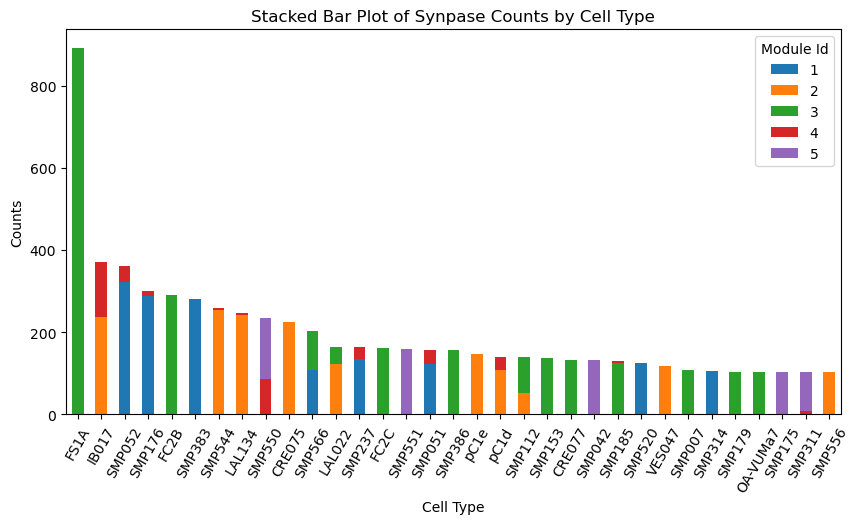

In [111]:
# Plot the stacked bar chart
ovi_in_pivot.plot(kind='bar', stacked=True, figsize=(10,5))

plt.title('Stacked Bar Plot of Synpase Counts by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Counts')
plt.legend(title='Module Id')
plt.xticks(rotation=60, ha='center')
plt.show()

In [112]:
# Testing whether the grouping and summing is correct by comparing the collapsed to the total column in the pivot table

# Adding up weights for each cell type
ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)

# Merging the correct data pulled from Neuprint
ovi_test = ovi_in_pivot.merge(ovi_inputs_final, how='left', left_on='celltype', right_on='type_pre')

# This confirms that during processing the data was not lost or altered
ovi_test

,1,2,3,4,5,total,type_pre,weight
0,NaN,NaN,892.0,NaN,NaN,892.0,FS1A,892
1,NaN,236.0,NaN,134.0,NaN,370.0,IB017,370
2,322.0,NaN,NaN,39.0,NaN,361.0,SMP052,361
3,287.0,NaN,NaN,12.0,NaN,299.0,SMP176,299
4,NaN,NaN,290.0,NaN,NaN,290.0,FC2B,290
5,281.0,NaN,NaN,NaN,NaN,281.0,SMP383,281
6,NaN,255.0,NaN,4.0,NaN,259.0,SMP544,259
7,NaN,243.0,NaN,4.0,NaN,247.0,LAL134,247
8,NaN,NaN,NaN,87.0,147.0,234.0,SMP550,234
9,NaN,225.0,NaN,NaN,NaN,225.0,CRE075,225
